In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob
from ipyfilechooser import FileChooser

In [2]:
fc = FileChooser('/sf/alvra/data/p18836/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18836/raw/scan_info', filename='', show_hidden='False')

In [10]:
quantile_band = 0.2

channel_list = [channel_PIPS_trans, channel_Izero117, channel_Izero122]

################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Position_mm = scan.readbacks

Signal = []
Izero117 = []
Izero122 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    results = load_data_compact(channel_list, step)
    
    Izero117_shot = results[channel_Izero117]      
    Izero122_shot = results[channel_Izero122]
    signal_shot = results[channel_PIPS_trans]
    
    signal_norm_shot = signal_shot / Izero117_shot              #Normalization with PBPS117
    #signal_norm_shot = signal_shot / Izero122_shot              #Normalization with PBPS122
            
    df_signal = pd.DataFrame(signal_norm_shot)
    Signal.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
    df_Izero117 = pd.DataFrame(Izero117_shot)
    Izero117.append(np.nanquantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
    df_Izero122 = pd.DataFrame(Izero122_shot)
    Izero122.append(np.nanquantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

Signal = np.asarray(Signal)
Izero117 = np.asarray(Izero117)
Izero122 = np.asarray(Izero122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 21 of 21: Processing run_000043

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY 241 / 250 -> 4% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 241 / 250 -> 4% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.4,0.6


<IPython.core.display.Javascript object>


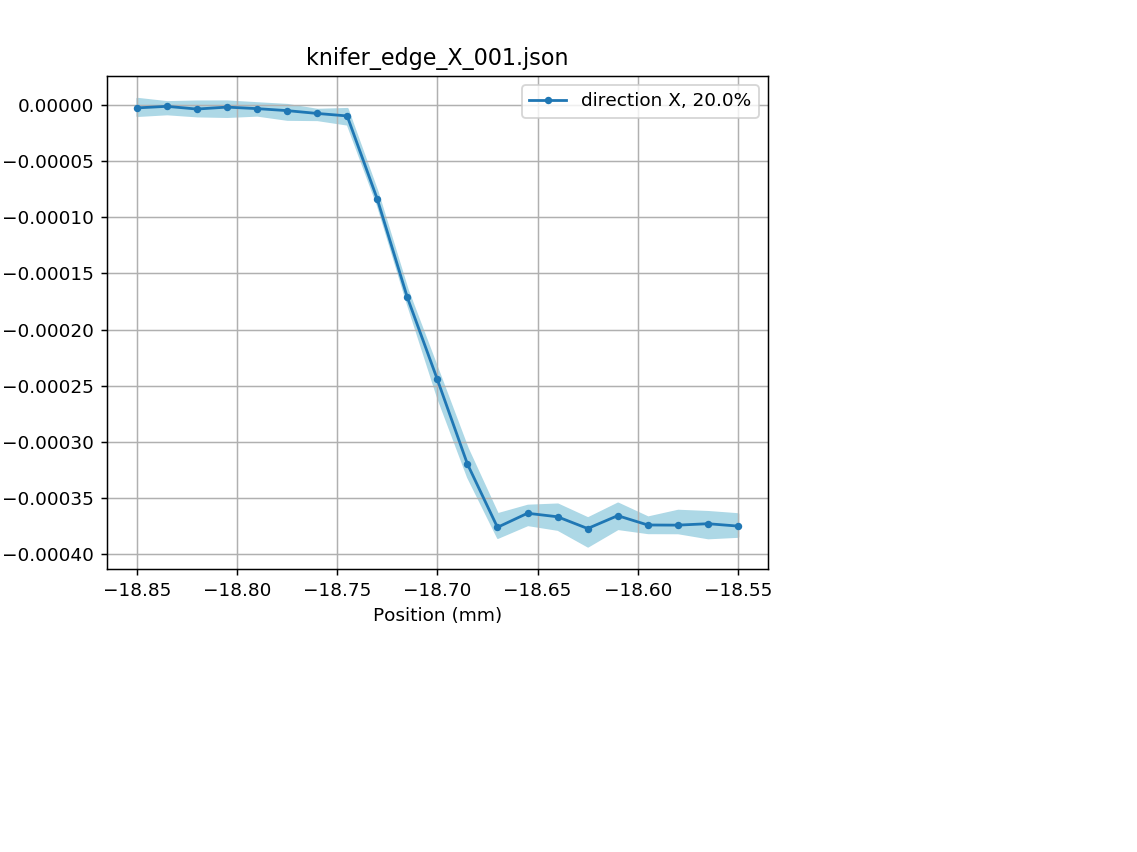

In [11]:
Int = Signal[:,0]
err_low = Signal[:,1]
err_high = Signal[:,2]

plt.figure()
plt.plot(Position_mm, Int, label='direction X, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low, err_high, color='lightblue')

plt.title(fc.selected_filename)
plt.ylabel('Normalized intensity')
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.grid()

plt.show()

In [12]:
# Now fit with error function (defined above)
parameters,extras = curve_fit(errfunc_fwhm, Position_mm, Int, p0 = [0, 10, -18.7, 0.1]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = -18.711 mm
Width = 0.054 mm


<IPython.core.display.Javascript object>


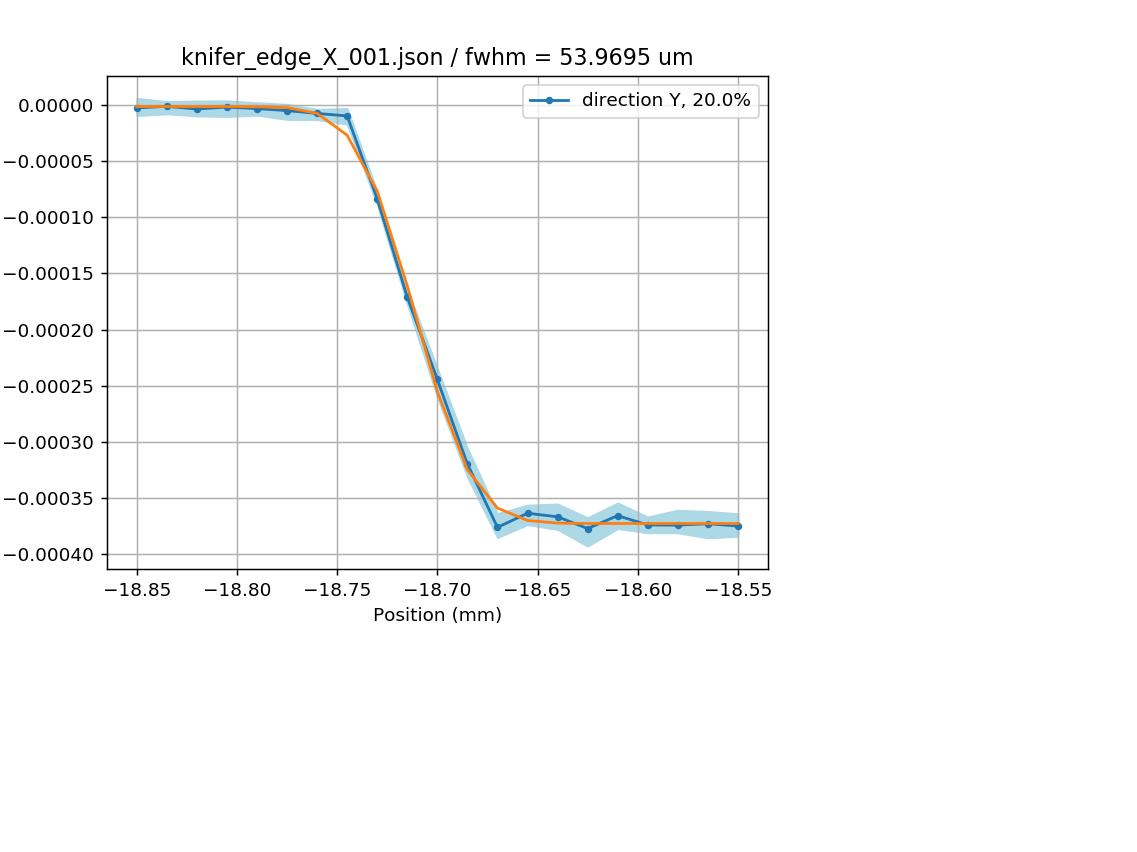

In [13]:
#... and the plot with the fit curve
plt.figure()

plt.plot(Position_mm, Int, label='direction Y, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low, err_high, color='lightblue')
plt.plot(Position_mm, errfunc_fwhm(Position_mm,*parameters))

plt.title(fc.selected_filename + ' / fwhm = {} um'.format(np.round(np.abs(parameters[3])*1000, 4)))
#plt.title("X direction")
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')